In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
import re
import emoji #dealing with emojis
import contractions

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\xmega\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xmega\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\xmega\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
a_posts_df = pd.read_csv("a_posts_df.csv")
a_comments_df = pd.read_csv("a_comments_df.csv")

a_posts_df.name = "Ath Posts"
a_comments_df.name = "Ath Comments"


## Exploratory Data Analysis

In [4]:
# head of data set
a_posts_df.head()

,post_id,post_title,post_author,post_score,post_url,post_text,num_comments,created_utc
0,i4agbh,The Satanic Temple just announced a Satanic Ri...,FunnyGeekReference23,100847,https://announcement.thesatanictemple.com/rrr-...,NaN,5213,1.596651e+09
1,vjpvsa,"In honor of today's Supreme Court ruling, I ju...",opequan,91882,https://www.reddit.com/r/atheism/comments/vjpv...,Fuck this oppressive religion that has insiste...,3069,1.656081e+09
2,ua3wb5,Florida atheist petitions to ban the Bible in ...,mepper,88065,https://www.miaminewtimes.com/news/broward-man...,NaN,3506,1.650715e+09
3,gm1j1j,"""Since the Bible says not to charge interest o...",mepper,83764,https://twitter.com/DrPsyBuffy/status/10964212...,NaN,1578,1.589809e+09
4,egd37r,"Teenager, 19, kills 'paedophile priest who abu...",[deleted],78030,https://www.dailymail.co.uk/news/article-78302...,NaN,1737,1.577464e+09


In [5]:
a_posts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   post_id       300 non-null    object 
 1   post_title    300 non-null    object 
 2   post_author   300 non-null    object 
 3   post_score    300 non-null    int64  
 4   post_url      300 non-null    object 
 5   post_text     64 non-null     object 
 6   num_comments  300 non-null    int64  
 7   created_utc   300 non-null    float64
dtypes: float64(1), int64(2), object(5)
memory usage: 18.9+ KB


In [5]:
a_comments_df.head()

,comment_id,post_id,post_title,comment_author,comment_body,comment_score,comment_parent_id
0,g0h93fe,i4agbh,The Satanic Temple just announced a Satanic Ri...,[deleted],The Satanic Temple is a critical watchdog on t...,11333,t3_i4agbh
1,g0hb3u3,i4agbh,The Satanic Temple just announced a Satanic Ri...,[deleted],“Prior to receiving any anesthetic or sedation...,5028,t3_i4agbh
2,g0gyr8l,i4agbh,The Satanic Temple just announced a Satanic Ri...,[deleted],[deleted],4549,t3_i4agbh
3,g0gyol4,i4agbh,The Satanic Temple just announced a Satanic Ri...,MissMarlaMoon,"Once again, Satan is the the logical, ethical ...",2647,t3_i4agbh
4,g0h66rl,i4agbh,The Satanic Temple just announced a Satanic Ri...,RealUserForSure,"We did it guys, we can officially say to the c...",2335,t3_i4agbh


In [6]:
a_comments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14921 entries, 0 to 14920
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   comment_id         14921 non-null  object 
 1   post_id            14921 non-null  object 
 2   post_title         14921 non-null  object 
 3   comment_author     14921 non-null  object 
 4   comment_body       14920 non-null  object 
 5   comment_score      14921 non-null  int64  
 6   comment_parent_id  14921 non-null  object 
 7   created_utc        14921 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 932.7+ KB


In [7]:
def create_edadf(*dataframes):
    eda_df = []
    for df in dataframes:
        eda_df.append({
            "name": df.name,
            "num_rows": df.shape[0],
            "num_cols": df.shape[1],
            "contains_null": df.isnull().any(axis = None)
        })
    return pd.DataFrame(eda_df)
    
p_eda_df = create_edadf(a_posts_df)
c_eda_df = create_edadf(a_comments_df)

In [8]:
p_eda_df

,name,num_rows,num_cols,contains_null
0,Ath Posts,10,7,True


In [9]:
c_eda_df

,name,num_rows,num_cols,contains_null
0,Ath Comments,300,7,False


## Preprocess text

In [10]:
a_comments_df = pd.read_csv("a_comments_df.csv")
a_comments_df

,comment_id,post_id,post_title,comment_author,comment_body,comment_score,comment_parent_id
0,g0h93fe,i4agbh,The Satanic Temple just announced a Satanic Ri...,[deleted],The Satanic Temple is a critical watchdog on t...,11333,t3_i4agbh
1,g0hb3u3,i4agbh,The Satanic Temple just announced a Satanic Ri...,[deleted],“Prior to receiving any anesthetic or sedation...,5028,t3_i4agbh
2,g0gyr8l,i4agbh,The Satanic Temple just announced a Satanic Ri...,[deleted],[deleted],4549,t3_i4agbh
3,g0gyol4,i4agbh,The Satanic Temple just announced a Satanic Ri...,MissMarlaMoon,"Once again, Satan is the the logical, ethical ...",2647,t3_i4agbh
4,g0h66rl,i4agbh,The Satanic Temple just announced a Satanic Ri...,RealUserForSure,"We did it guys, we can officially say to the c...",2335,t3_i4agbh
...,...,...,...,...,...,...,...
295,idov4dr,vkcw9h,The Satanic Temple: Our members can assert a r...,[deleted],[deleted],10,t3_vkcw9h
296,idou5iw,vkcw9h,The Satanic Temple: Our members can assert a r...,krunklestiltzkin,Hail Satan,9,t3_vkcw9h
297,idp1k5f,vkcw9h,The Satanic Temple: Our members can assert a r...,brutishbloodgod,The Satanic Temple has been gathering a great ...,9,t3_vkcw9h
298,idp2483,vkcw9h,The Satanic Temple: Our members can assert a r...,[deleted],The Satanic Temple is about to get a boost in ...,10,t3_vkcw9h


In [11]:
def preprocess_df(df, type = "post_title"):
    #CLEAN TEXT
    processed_texts = []

    #loading stop words and objects from classes
    stop_words = set(stopwords.words('english'))
    lmtzr = WordNetLemmatizer()

    # for each text in df.post_title:
    for sentence in df[type]:
        #BASIC CLEANING
        #convert emojis to text
        sentence = emoji.demojize(sentence) 
        #remove new lines
        sentence = re.sub(r'\\n|:|_',' ', sentence)
        #remove punctuations
        sentence = re.sub(r'[^a-zA-Z0-9\s]', '', sentence)
        #convert all text to lower case
        sentence = sentence.lower()

        #tokenize words
        tokens = word_tokenize(sentence)

        final_words = []
        for word in tokens: #for each word in the sentence
            fixed_word = contractions.fix(word) #expand contractions
            if fixed_word not in stop_words:
                lemma = lmtzr.lemmatize(fixed_word) #lemmatize words
                final_words.append(lemma) #append the singular lemmatized word to the final_words list

        processed_texts.append(' '.join(final_words)) #append the list of words to processed_text

    df[type] = processed_texts #this is a list of all the processed texts
    return df

In [12]:
a_comment_df = preprocess_df(a_comments_df, type = "comment_body")
a_comment_df["comment_body"]

0      satanic temple critical watchdog judiciary tes...
1      prior receiving anesthetic sedation look refle...
2                                                deleted
3      satan logical ethical choice raising hand ligh...
4      guy officially say conservative practice satan...
                             ...                        
295                                              deleted
296                                           hail satan
297    satanic temple gathering great deal publicity ...
298    satanic temple get boost membership also do no...
299    know satanic temple is not organization actual...
Name: comment_body, Length: 300, dtype: object

In [13]:
from sklearn.model_selection import train_test_split
train_c, test_c = train_test_split(a_comment_df, test_size = 0.2, random_state=42)

# Visualizations

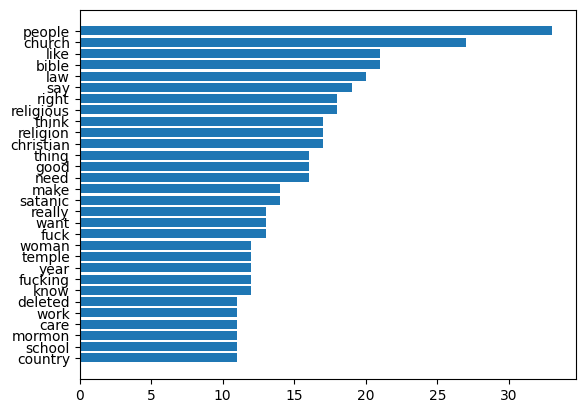

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
X_counts = vectorizer.fit_transform(train_c["comment_body"])

w_counts = X_counts.toarray().sum(axis = 0)
word_freq = [(word, w_counts[idx])for word, idx in vectorizer.vocabulary_.items()]
word_freq = sorted(word_freq, key=lambda x: x[1], reverse = True)

words = [w[0] for w in word_freq[:30]]
counts = [w[1] for w in word_freq[:30]]
fig, ax = plt.subplots()
ax.barh(words, counts, align = "center")
ax.invert_yaxis()
plt.show()

In [15]:
#df of word counts
data = {"Words": words, "Counts": counts}
word_freq_df = pd.DataFrame(data)
word_freq_df


,Words,Counts
0,people,33
1,church,27
2,like,21
3,bible,21
4,law,20
5,say,19
6,right,18
7,religious,18
8,think,17
9,religion,17


In [16]:
comment_text = ' '.join(word for word in train_c["comment_body"])

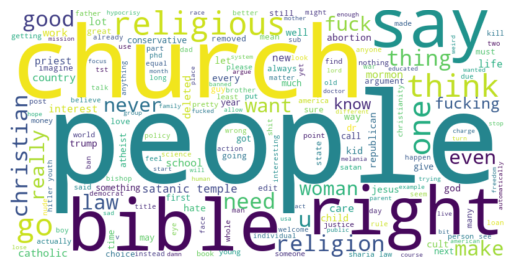

In [17]:
wordcloud = WordCloud(width = 800, height = 400, background_color= "white").generate(comment_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Vectorize Text

In [ ]:
vectorizer = TfidfVectorizer(lowercase = True, 
                             max_features=100,
                             max_df = 0.8, #remove words occuring more than x% time in document
                             min_df = 5, #remove words occur less than x times in doc
                             ngram_range = (1,3), #look for one word up to trigrams
                             stop_words= "english")
X = vectorizer.fit_transform(train_c["comment_body"])

In [ ]:
X.shape

(240, 1965)

In [ ]:
feature_names = vectorizer.get_feature_names_out()


In [ ]:
df_tfidf = pd.DataFrame(X.toarray(), columns=feature_names)
for col in df_tfidf:
    if(df_tfidf[col] == 1).any():
        print(col)

amen
deleted
disqualifying
good
interesting
removed
rupliftingnews
suck
yes


In [24]:
from gensim.models import Word2Vec

ModuleNotFoundError: No module named 'gensim'